# Demo of an MLP neural network Leo transpilation - MNIST dataset

MLP neural networks are expressive ML models. Here, we use them for the MNIST classification task, which contains images of handwritten digits. We show the inference of MLP neural networks for the MNIST dataset is possible in a zero knowledge environment.

For this, we first download the dataset, and then compute feature representations of the dataset. We then train and test an MLP neural network on the feature dataset using PyTorch (because we can train with L1 regularization which is helpful for pruning later on). Afterward, we iteratively prune the network (meaning we set weights and biases close to 0 to actually 0, this will save circuitconstraints later on) and fine-tune it. Then, we convert the final PyTorch MLP model to a scikit-learn MLP model (since the transpiler supports scikit-learn models) and transpile the final MLP neural network to Leo, evaluate the Leo network and create a zero knowledge proof.

## Define function to download the dataset

In [1]:
import gzip
import os
import shutil

import requests


def download_and_extract_dataset(url, save_path, folder_path):
    """Download and extract dataset if it doesn't exist."""
    if not os.path.exists(save_path):
        print(f"Downloading {os.path.basename(save_path)}...")
        response = requests.get(url)
        with open(save_path, "wb") as file:
            file.write(response.content)

        decompressed_file_name = os.path.splitext(os.path.basename(save_path))[0]
        decompressed_file_path = os.path.join(folder_path, decompressed_file_name)

        with gzip.open(save_path, "rb") as f_in:
            with open(decompressed_file_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)

        print(f"{decompressed_file_name} downloaded and extracted.")
    else:
        print(f"{os.path.basename(save_path)} already exists.")

## Download the dataset

In [2]:
# URLs and filenames
file_info = [
    (
        "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
        "train-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
        "train-labels-idx1-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
        "t10k-images-idx3-ubyte.gz",
    ),
    (
        "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
        "t10k-labels-idx1-ubyte.gz",
    ),
]

folder_name = "tmp/mnist"
folder_path = os.path.join(os.getcwd(), folder_name)

os.makedirs(folder_path, exist_ok=True)  # Create folder if it doesn't exist

# Download and extract each file
for url, file_name in file_info:
    path_to_save = os.path.join(folder_path, file_name)
    download_and_extract_dataset(url, path_to_save, folder_path)

train-images-idx3-ubyte.gz already exists.
train-labels-idx1-ubyte.gz already exists.
t10k-images-idx3-ubyte.gz already exists.
t10k-labels-idx1-ubyte.gz already exists.


## Define function to read the dataset

In [3]:
import numpy as np


def read_idx3_ubyte_image_file(filename):
    """Read IDX3-ubyte formatted image data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_images = int.from_bytes(f.read(4), byteorder="big")
        num_rows = int.from_bytes(f.read(4), byteorder="big")
        num_cols = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2051:
            raise ValueError(f"Invalid magic number: {magic_num}")

        images = np.zeros((num_images, num_rows, num_cols), dtype=np.uint8)

        for i in range(num_images):
            for r in range(num_rows):
                for c in range(num_cols):
                    pixel = int.from_bytes(f.read(1), byteorder="big")
                    images[i, r, c] = pixel

    return images


def read_idx1_ubyte_label_file(filename):
    """Read IDX1-ubyte formatted label data."""
    with open(filename, "rb") as f:
        magic_num = int.from_bytes(f.read(4), byteorder="big")
        num_labels = int.from_bytes(f.read(4), byteorder="big")

        if magic_num != 2049:
            raise ValueError(f"Invalid magic number: {magic_num}")

        labels = np.zeros(num_labels, dtype=np.uint8)

        for i in range(num_labels):
            labels[i] = int.from_bytes(f.read(1), byteorder="big")

    return labels

## Read the dataset

In [4]:
folder_path = os.path.join(
    os.getcwd(), folder_name
)  # Adjust this path to where you stored the files

train_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "train-images-idx3-ubyte")
)
train_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "train-labels-idx1-ubyte")
)
test_images = read_idx3_ubyte_image_file(
    os.path.join(folder_path, "t10k-images-idx3-ubyte")
)
test_labels = read_idx1_ubyte_label_file(
    os.path.join(folder_path, "t10k-labels-idx1-ubyte")
)

print(
    f"Shape of train_images: {train_images.shape}"
)  # Should output "Shape of train_images: (60000, 28, 28)"
print(
    f"Shape of train_labels: {train_labels.shape}"
)  # Should output "Shape of train_labels: (60000,)"
print(
    f"Shape of test_images: {test_images.shape}"
)  # Should output "Shape of test_images: (10000, 28, 28)"
print(
    f"Shape of test_labels: {test_labels.shape}"
)  # Should output "Shape of test_labels: (10000,)"

Shape of train_images: (60000, 28, 28)
Shape of train_labels: (60000,)
Shape of test_images: (10000, 28, 28)
Shape of test_labels: (10000,)


## Convert the datasets to PyTorch tensors, and get a validation set
(We use PyTorch instead of sci-kit learn to train sparse neural networks with L1 regularization)

In [5]:
# convertto pytorch tensors
import torch

train_images_tensor_initial = torch.from_numpy(train_images).float()
train_labels_tensor_initial = torch.from_numpy(train_labels).long()
test_images_tensor = torch.from_numpy(test_images).float()
test_labels_tensor = torch.from_numpy(test_labels).long()

# seed the random number generator
torch.manual_seed(0)

# shuffle the training dataset
indices = torch.randperm(train_images_tensor_initial.shape[0])
train_images_tensor_shuffled = train_images_tensor_initial[indices]
train_labels_tensor_shuffled = train_labels_tensor_initial[indices]

# get a 10% validation set
validation_size = int(train_images_tensor_shuffled.shape[0] * 0.1)
validation_images_tensor = train_images_tensor_shuffled[:validation_size]
validation_labels_tensor = train_labels_tensor_shuffled[:validation_size]
train_images_tensor = train_images_tensor_shuffled[validation_size:]
train_labels_tensor = train_labels_tensor_shuffled[validation_size:]

In [6]:
print("Train labels tensor shape:", train_labels_tensor.shape)
print("Validation labels tensor shape:", validation_labels_tensor.shape)
print("Test labels tensor shape:", test_labels_tensor.shape)

Train labels tensor shape: torch.Size([54000])
Validation labels tensor shape: torch.Size([6000])
Test labels tensor shape: torch.Size([10000])


In [7]:
print(train_images_tensor[0])

tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0., 113., 255., 248.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,

## Extract feature representations of the dataset

(We transform the bounding box images to 12x12 images, defined by the new_size variable. There is a trade-off in circuit constraints and ML model accuracy. You can increase the image size which will lead to a higher accuracy at the cost of more circuit constraints and thus longer proving times.)

In [8]:
import numpy as np


def get_bounding_box(img):
    """
    Extract the bounding box from an MNIST image.

    Args:
        img (np.ndarray): 2D numpy array representing the MNIST image.

    Returns:
        (np.ndarray): Cropped image with the bounding box.
    """

    # convert torch image to numpy array
    img = img.numpy()

    # Find the rows and columns where the image has non-zero pixels
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)

    # Find the first and last row and column indices where the image has non-zero pixels
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # Return the cropped image
    return img[rmin : rmax + 1, cmin : cmax + 1]

In [9]:
def resize_image(image, new_size):
    height, width = image.shape
    resized_image = np.zeros((new_size, new_size), dtype=np.uint8)

    x_scale = width / new_size
    y_scale = height / new_size

    for i in range(new_size):
        for j in range(new_size):
            x_start = j * x_scale
            y_start = i * y_scale
            x_end = (j + 1) * x_scale
            y_end = (i + 1) * y_scale

            sum_pixels = 0
            count = 0

            for y in range(int(y_start), int(y_end)):
                for x in range(int(x_start), int(x_end)):
                    if 0 <= y < height and 0 <= x < width:
                        sum_pixels += image[y, x]
                        count += 1

            resized_image[i, j] = round(sum_pixels / count) if count > 0 else 0

    return resized_image


In [10]:
cropped_test_image_0 = None

def get_resized_datasets(
    train_images_tensor, validation_images_tensor, test_images_tensor, new_size
):
    num_train = len(train_images_tensor)
    num_test = len(test_images_tensor)
    num_val = len(validation_images_tensor)

    train_images_tensor_resized = np.zeros((num_train, new_size**2))
    validation_images_tensor_resized = np.zeros((num_val, new_size**2))
    test_images_tensor_resized = np.zeros((num_test, new_size**2))

    for i in range(num_train):
        cropped_image = get_bounding_box(train_images_tensor[i].reshape(28, 28))
        cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
        resized_image = resize_image(
            cropped_image_uint8, new_size
        )
        train_images_tensor_resized[i, :] = resized_image.flatten()

    for i in range(num_val):
        cropped_image = get_bounding_box(validation_images_tensor[i].reshape(28, 28))
        cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
        resized_image = resize_image(
            cropped_image_uint8, new_size
        )
        validation_images_tensor_resized[i, :] = resized_image.flatten()

    for i in range(num_test):
        cropped_image = get_bounding_box(test_images_tensor[i].reshape(28, 28))
        cropped_image_uint8 = np.clip(cropped_image, 0, 255).astype(np.uint8)
        if(i == 0):
            global cropped_test_image_0
            cropped_test_image_0 = cropped_image_uint8
        resized_image = resize_image(
            cropped_image_uint8, new_size
        )
        test_images_tensor_resized[i, :] = resized_image.flatten()

    return (
        train_images_tensor_resized,
        validation_images_tensor_resized,
        test_images_tensor_resized,
    )

In [11]:
new_size = 12
train_images_resized, val_images_resized, test_images_resized = get_resized_datasets(
    train_images_tensor, validation_images_tensor, test_images_tensor, new_size
)

## Let's compute the features

In [12]:
def compute_integral_image(image):
    integral_image = np.cumsum(np.cumsum(image, axis=0), axis=1)
    return integral_image

def sum_region(integral_image, top_left, bottom_right):
    # Sum of region using the integral image
    tl_y, tl_x = top_left
    br_y, br_x = bottom_right
    
    total = integral_image[br_y, br_x]
    if tl_y > 0:
        total -= integral_image[tl_y - 1, br_x]
    if tl_x > 0:
        total -= integral_image[br_y, tl_x - 1]
    if tl_y > 0 and tl_x > 0:
        total += integral_image[tl_y - 1, tl_x - 1]
    
    return total

def compute_haar_features(image):
    if image.shape[0] != image.shape[1]:
        raise ValueError("The input image must be square.")

    integral_image = compute_integral_image(image)
    features = []

    for i in range(0, image.shape[0], 3):  # Slide vertically with a step of 3
        for j in range(0, image.shape[0], 3):  # Slide horizontally with a step of 3

            if i + 6 > image.shape[0] or j + 6 > image.shape[0]:
                continue

            # Horizontal feature
            horizontal_feature_value = sum_region(integral_image, (i, j), (i+2, j+5)) - sum_region(integral_image, (i+3, j), (i+5, j+5))

            # Vertical feature
            vertical_feature_value = sum_region(integral_image, (i, j), (i+5, j+2)) - sum_region(integral_image, (i, j+3), (i+5, j+5))

            features.append(horizontal_feature_value)
            features.append(vertical_feature_value)

    return np.array(features)


def aspect_ratio(image, threshold=0.5):
    # Threshold the image to create a binary representation
    bin_image = image > threshold
    # Find the bounding box
    row_indices, col_indices = np.nonzero(bin_image)
    max_row, min_row = np.max(row_indices), np.min(row_indices)
    max_col, min_col = np.max(col_indices), np.min(col_indices)

    # Calculate the aspect ratio of the bounding box
    width = max_col - min_col + 1
    height = max_row - min_row + 1

    if height == 0:  # To avoid division by zero
        return 1.0

    return width / height


from scipy.ndimage import label


def num_regions_below_threshold(image, threshold=0.5):
    # Threshold the image so that pixels below the threshold are set to 1
    # and those above the threshold are set to 0.
    bin_image = image < threshold

    # Use connected components labeling
    labeled_array, num_features = label(bin_image)

    # Return the number of unique regions
    # (subtracting 1 as one of the labels will be the background)
    return num_features

In [13]:
# compute datasets

num_train = len(train_images_tensor)
num_val = len(validation_images_tensor)
num_test = len(test_images_tensor)

aspect_ratio_train = np.zeros(num_train)
aspect_ratio_val = np.zeros(num_val)
aspect_ratio_test = np.zeros(num_test)

num_white_regions_train = np.zeros(num_train)
num_white_regions_val = np.zeros(num_val)
num_white_regions_test = np.zeros(num_test)

haar_1 = compute_haar_features(train_images_resized[0].reshape(new_size, new_size))
len_haar_features = len(haar_1)

haar_train = np.zeros((num_train, len_haar_features))
haar_val = np.zeros((num_val, len_haar_features))
haar_test = np.zeros((num_test, len_haar_features))

for i in range(num_train):
    aspect_ratio_train[i] = aspect_ratio(train_images_tensor[i].reshape(28, 28).numpy())
    num_white_regions_train[i] = num_regions_below_threshold(
        train_images_tensor[i].reshape(28, 28)
    )
    haar_train[i, :] = compute_haar_features(
        train_images_resized[i, :].reshape(new_size, new_size)
    )

for i in range(num_val):
    aspect_ratio_val[i] = aspect_ratio(
        validation_images_tensor[i].reshape(28, 28).numpy()
    )
    num_white_regions_val[i] = num_regions_below_threshold(
        validation_images_tensor[i].reshape(28, 28)
    )
    haar_val[i, :] = compute_haar_features(
        val_images_resized[i, :].reshape(new_size, new_size)
    )

for i in range(num_test):
    aspect_ratio_test[i] = aspect_ratio(test_images_tensor[i].reshape(28, 28).numpy())
    num_white_regions_test[i] = num_regions_below_threshold(
        test_images_tensor[i].reshape(28, 28)
    )
    haar_test[i, :] = compute_haar_features(
        test_images_resized[i, :].reshape(new_size, new_size)
    )

## Take a look at the images, and the computed features

Original image


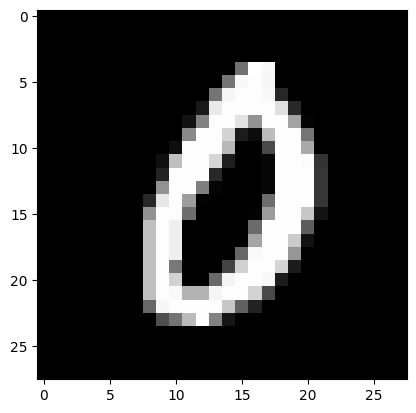

Image shape torch.Size([28, 28])
Label tensor(0)
Resized image


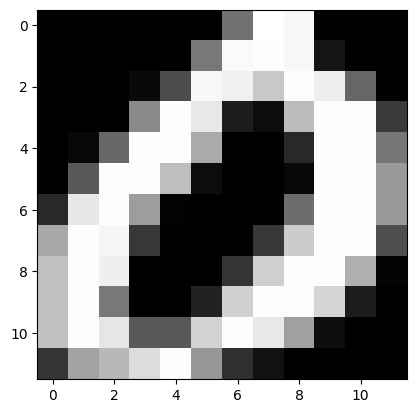

Image shape (12, 12)
Haar features: [-1755. -1751.   484.  -128.   297.   125.   118.   364.   934.   812.
  -434. -2370.  -598.  2250. -1380. -1040.   879.   373.]
Shape of Haar features: (18,)
Aspect ratio: 0.7
Number of white regions: 2.0


In [14]:
image_id = 0

image = train_images_tensor[image_id].reshape(28, 28)

print("Original image")

import matplotlib.pyplot as plt

plt.imshow(image, cmap="gray")
plt.show()

print("Image shape", image.shape)
print("Label", train_labels_tensor[image_id])

print("Resized image")

image_resized = train_images_resized[image_id].reshape(new_size, new_size)

plt.imshow(image_resized, cmap="gray")
plt.show()

print("Image shape", image_resized.shape)

print("Haar features:", haar_train[image_id, :])
print("Shape of Haar features:", haar_train[image_id, :].shape)

print("Aspect ratio:", aspect_ratio_train[image_id])
print("Number of white regions:", num_white_regions_train[image_id])

## Let's merge all features into one dataset

In [15]:
# compute datasets

train_features = np.zeros((num_train, len_haar_features + 2))
val_features = np.zeros((num_val, len_haar_features + 2))
test_features = np.zeros((num_test, len_haar_features + 2))

for i in range(num_train):
    train_features[i, :] = np.hstack(
        (haar_train[i, :], aspect_ratio_train[i], num_white_regions_train[i])
    )

for i in range(num_val):
    val_features[i, :] = np.hstack(
        (haar_val[i, :], aspect_ratio_val[i], num_white_regions_val[i])
    )

for i in range(num_test):
    test_features[i, :] = np.hstack(
        (haar_test[i, :], aspect_ratio_test[i], num_white_regions_test[i])
    )

In [16]:
print("Shape of training features:", train_features.shape)
print("First training feature vector:", train_features[0, :])

Shape of training features: (54000, 20)
First training feature vector: [-1.755e+03 -1.751e+03  4.840e+02 -1.280e+02  2.970e+02  1.250e+02
  1.180e+02  3.640e+02  9.340e+02  8.120e+02 -4.340e+02 -2.370e+03
 -5.980e+02  2.250e+03 -1.380e+03 -1.040e+03  8.790e+02  3.730e+02
  7.000e-01  2.000e+00]


## Normalize the dataset

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features_normalized = torch.tensor(scaler.fit_transform(train_features)).float()
val_features_normalized = torch.tensor(scaler.transform(val_features)).float()
test_features_normalized = torch.tensor(scaler.transform(test_features)).float()

# print normalizing parameters
print("Mean:", scaler.mean_)
print("Standard deviation:", scaler.scale_)

# print mean as javascript array
print("Mean:", scaler.mean_.tolist())

# print standard deviation as javascript array
print("Standard deviation:", scaler.scale_.tolist())

Mean: [-156.89455556 -746.57240741  181.82409259 -233.12468519  215.89527778
  263.25757407  -26.51775926 -543.36164815  -95.56633333 -166.66537037
   12.45133333  338.88711111 -328.52153704 -618.70875926 -104.3222963
   63.83240741  266.76446296  587.49375926    0.80027855    1.64944444]
Standard deviation: [1.04394811e+03 9.22641317e+02 1.08172584e+03 9.85078247e+02
 8.74984717e+02 1.12660933e+03 1.00850222e+03 1.12867243e+03
 1.08860804e+03 1.05573917e+03 9.81360965e+02 1.34469105e+03
 1.02263037e+03 9.90665097e+02 1.18404377e+03 1.17523292e+03
 8.17505785e+02 1.20897397e+03 2.21488782e-01 8.68779298e-01]
Mean: [-156.89455555555554, -746.5724074074074, 181.8240925925926, -233.12468518518517, 215.89527777777778, 263.25757407407406, -26.51775925925926, -543.3616481481481, -95.56633333333333, -166.66537037037037, 12.451333333333332, 338.8871111111111, -328.52153703703704, -618.7087592592593, -104.3222962962963, 63.83240740740741, 266.76446296296297, 587.4937592592593, 0.800278554246832

In [18]:
print("First training feature vector (normalized):", train_features_normalized[0, :])

First training feature vector (normalized): tensor([-1.5308, -1.0886,  0.2793,  0.1067,  0.0927, -0.1227,  0.1433,  0.8039,
         0.9458,  0.9270, -0.4549, -2.0145, -0.2635,  2.8957, -1.0774, -0.9392,
         0.7489, -0.1774, -0.4527,  0.4035])


## Define the neural network and the training and test function

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score


def evaluate_model(model, test_labels):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_outputs = model(test_features_normalized)
        _, predicted = torch.max(test_outputs.data, 1)
        accuracy = accuracy_score(test_labels, predicted.numpy())
        print("Accuracy:", accuracy)
        return accuracy


# Define the PyTorch neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def train(model, train_labels, val_labels):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop with L1 regularization
    lambda_l1 = 0.0001  # L1 regularization coefficient

    validation_losses = []
    epoch = 0

    model_states = []

    while True:
        optimizer.zero_grad()
        outputs = model(train_features_normalized)

        loss = criterion(outputs, train_labels)

        # Add L1 regularization
        l1_reg = torch.tensor(0.0, requires_grad=True)
        for param in model.parameters():
            l1_reg = l1_reg + torch.norm(param, 1)
        loss += lambda_l1 * l1_reg

        loss.backward()
        optimizer.step()

        # Print progress
        if (epoch + 1) % 100 == 0:
            print(
                f"Epoch [{epoch + 1}], Loss: {loss.item():.4f}, validation loss: {validation_losses[-1]:.4f}"
            )

        # store model state
        model_states.append(model.state_dict())

        # Compute validation loss
        with torch.no_grad():
            outputs = model(val_features_normalized)
            loss = criterion(outputs, val_labels)
            validation_losses.append(loss.item())

        # Check for early stopping if no improvement in validation loss in last 10 epochs
        if epoch > 10 and validation_losses[-1] > validation_losses[-10]:
            print("Early stopping")
            break

        epoch += 1

    best_model_state = model_states[np.argmin(validation_losses)]
    model.load_state_dict(best_model_state)
    validation_loss_of_best_model = validation_losses[np.argmin(validation_losses)]

    return model, epoch, validation_loss_of_best_model

## Let's create and train a model

In [20]:
# Hyperparameters
input_dim = train_features_normalized.shape[1]
output_dim = len(set(train_labels))  # Assuming train_labels are class indices
hidden_dim = (input_dim + output_dim) // 2

# Instantiate the model
model = SimpleNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

In [21]:
# Train the model
model, epochs, val_loss = train(model, train_labels_tensor, validation_labels_tensor)

Epoch [100], Loss: 1.6662, validation loss: 1.6651
Epoch [200], Loss: 0.9860, validation loss: 0.9828
Epoch [300], Loss: 0.6444, validation loss: 0.6410
Epoch [400], Loss: 0.4980, validation loss: 0.4945
Epoch [500], Loss: 0.4302, validation loss: 0.4264
Epoch [600], Loss: 0.3938, validation loss: 0.3899
Epoch [700], Loss: 0.3716, validation loss: 0.3674
Epoch [800], Loss: 0.3566, validation loss: 0.3523
Epoch [900], Loss: 0.3460, validation loss: 0.3416
Epoch [1000], Loss: 0.3381, validation loss: 0.3337
Epoch [1100], Loss: 0.3319, validation loss: 0.3276
Epoch [1200], Loss: 0.3269, validation loss: 0.3226
Epoch [1300], Loss: 0.3226, validation loss: 0.3181
Epoch [1400], Loss: 0.3190, validation loss: 0.3141
Epoch [1500], Loss: 0.3158, validation loss: 0.3107
Epoch [1600], Loss: 0.3128, validation loss: 0.3075
Epoch [1700], Loss: 0.3100, validation loss: 0.3045
Epoch [1800], Loss: 0.3073, validation loss: 0.3017
Epoch [1900], Loss: 0.3046, validation loss: 0.2989
Epoch [2000], Loss: 0

In [22]:
evaluate_model(model, test_labels)

Accuracy: 0.9363


0.9363

## Let's prune the model

In [23]:
def prune_pytorch_network(
    model, weight_threshold=1e-1, bias_threshold=1e-1
):  # noqa: D103
    num_weights = 0
    num_weights_already_zero = 0
    num_changed_weights = 0
    num_biases = 0
    num_biases_already_zero = 0
    num_changed_biases = 0

    # Pruning the weights
    for name, param in model.named_parameters():
        if "weight" in name:
            flattened_weights = param.data.view(-1)
            for j, weight in enumerate(flattened_weights):
                if weight == 0:
                    num_weights_already_zero += 1
                elif abs(weight) < weight_threshold:
                    flattened_weights[j] = 0
                    num_changed_weights += 1
                num_weights += 1
            param.data = flattened_weights.view(param.data.shape)
        elif "bias" in name:
            flattened_biases = param.data.view(-1)
            for j, bias in enumerate(flattened_biases):
                if bias == 0:
                    num_biases_already_zero += 1
                elif abs(bias) < bias_threshold:
                    flattened_biases[j] = 0
                    num_changed_biases += 1
                num_biases += 1
            param.data = flattened_biases.view(param.data.shape)

    # Set gradients of pruned weights to zero
    def zero_gradients_hook(grad):
        return grad * (grad != 0)

    hooks = []
    for name, param in model.named_parameters():
        if "weight" in name or "bias" in name:
            hooks.append(param.register_hook(zero_gradients_hook))

    print(f"Number of weight parameters: {num_weights}")  # noqa: T201
    print(f"Number of weights already zero: {num_weights_already_zero}")  # noqa: T201
    print(f"Number of changed weight parameters: {num_changed_weights}")  # noqa: T201
    print(f"Number of bias parameters: {num_biases}")  # noqa: T201
    print(f"Number of biases already zero: {num_biases_already_zero}")  # noqa: T201
    print(f"Number of changed bias parameters: {num_changed_biases}")  # noqa: T201
    print(  # noqa: T201
        f"Percentage of weights pruned: {num_changed_weights / num_weights * 100:.2f}%"
    )
    print(  # noqa: T201
        f"Percentage of biases pruned: {num_changed_biases / num_biases * 100:.2f}%"
    )
    print(  # noqa: T201
        f"Remaining number of non-zero weights: {num_weights - num_changed_weights}"
    )
    print(  # noqa: T201
        f"Remaining number of non-zero biases: {num_biases - num_changed_biases}"
    )

    return model, hooks

In [24]:
import copy

model_pruned = copy.deepcopy(model)
model_pruned, hooks = prune_pytorch_network(model_pruned, 1e-1, 1e-1)

_ = evaluate_model(model_pruned, test_labels)

Number of weight parameters: 450
Number of weights already zero: 0
Number of changed weight parameters: 123
Number of bias parameters: 25
Number of biases already zero: 0
Number of changed bias parameters: 4
Percentage of weights pruned: 27.33%
Percentage of biases pruned: 16.00%
Remaining number of non-zero weights: 327
Remaining number of non-zero biases: 21
Accuracy: 0.9341


## Let's have a loop of fine-tuning, pruning, and evaluating

In [25]:
i = 0
val_loss_new = val_loss
model_to_prune = copy.deepcopy(model)

while True:
    print(f"Iteration {i}")
    model_pruned = copy.deepcopy(model_to_prune)
    model_pruned, _ = prune_pytorch_network(model_pruned, 1e-1, 1e-1)
    val_loss_old = val_loss_new

    model_to_prune = copy.deepcopy(model_pruned)
    print("Now training")
    model_to_prune, _, val_loss_new = train(model_to_prune, train_labels_tensor, validation_labels_tensor)

    if val_loss_new > val_loss_old:
        print("Early stopping")
        break

    i += 1

accuracy = evaluate_model(model_pruned, test_labels)

Iteration 0
Number of weight parameters: 450
Number of weights already zero: 0
Number of changed weight parameters: 123
Number of bias parameters: 25
Number of biases already zero: 0
Number of changed bias parameters: 4
Percentage of weights pruned: 27.33%
Percentage of biases pruned: 16.00%
Remaining number of non-zero weights: 327
Remaining number of non-zero biases: 21
Now training
Early stopping
Iteration 1
Number of weight parameters: 450
Number of weights already zero: 0
Number of changed weight parameters: 126
Number of bias parameters: 25
Number of biases already zero: 0
Number of changed bias parameters: 4
Percentage of weights pruned: 28.00%
Percentage of biases pruned: 16.00%
Remaining number of non-zero weights: 324
Remaining number of non-zero biases: 21
Now training
Epoch [100], Loss: 0.2307, validation loss: 0.2188
Early stopping
Iteration 2
Number of weight parameters: 450
Number of weights already zero: 0
Number of changed weight parameters: 133
Number of bias paramete

## Let's convert this model to a scikit-learn MLP model

In [26]:
from sklearn.neural_network import MLPClassifier


def pytorch_to_sklearn(pytorch_model):

    # Extract weights and biases from PyTorch model
    fc1_weight = pytorch_model.fc1.weight.data
    fc1_bias = pytorch_model.fc1.bias.data
    fc2_weight = pytorch_model.fc2.weight.data
    fc2_bias = pytorch_model.fc2.bias.data

    # Get the sizes for initialization
    input_size = fc1_weight.shape[1]
    hidden_size = fc1_weight.shape[0]
    output_size = fc2_weight.shape[0]

    # Initialize sklearn MLP
    sklearn_mlp = MLPClassifier(
        hidden_layer_sizes=(hidden_size,), activation="relu", max_iter=1
    )

    # To ensure the model doesn't change the weights during the dummy fit, we set warm_start=True
    sklearn_mlp.warm_start = True

    # Dummy fit to initialize weights (necessary step before setting the weights)
    sklearn_mlp.fit(np.zeros((output_size, input_size)), list(range(output_size)))

    # Set the weights and biases
    sklearn_mlp.coefs_[0] = fc1_weight.t().numpy()
    sklearn_mlp.intercepts_[0] = fc1_bias.numpy()
    sklearn_mlp.coefs_[1] = fc2_weight.t().numpy()
    sklearn_mlp.intercepts_[1] = fc2_bias.numpy()

    return sklearn_mlp


# Convert the example PyTorch MLP to sklearn MLP
converted_model = pytorch_to_sklearn(model_pruned)

/Users/kp/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


In [27]:
# Evaluate the sklearn model
accuracy = converted_model.score(test_features_normalized.numpy(), test_labels)
print("Accuracy:", accuracy)

layers_sizes = [converted_model.coefs_[0].shape[0]] + [
    coef.shape[1] for coef in converted_model.coefs_
]

print("Number of neurons per layer:", layers_sizes)

Accuracy: 0.9361
Number of neurons per layer: [20, 15, 10]


## Let's transpile this model to Leo

In [28]:
from zkml import LeoTranspiler

# Transpile the deceision tree into Leo code
print(type(converted_model))
lt = LeoTranspiler(
    model=converted_model, validation_data=train_features_normalized[0:600].numpy()
)
leo_project_path = os.path.join(os.getcwd(), "tmp", "mnist")
leo_project_name = "sklearn_mlp_mnist_1"
lt.to_leo(
    path=leo_project_path, project_name=leo_project_name, fixed_point_scaling_factor=16
)

# Compute the accuracy of the Leo program and the Python program on the test set
num_test_samples = len(test_features)

# let's limit the number of test stamples to 10 to make the computation faster
num_test_samples = min(num_test_samples, 10)

python_predictions = converted_model.predict(test_features)

leo_predictions = np.zeros(num_test_samples)
for i in range(num_test_samples):
    lc = lt.run(input=test_features[i])
    leo_predictions[i] = np.argmax(lc.output_decimal)

print(f"Constraints: {lc.circuit_constraints}")
print(f"Runtime for one instance: {lc.runtime} seconds")

leo_accuracy = (
    np.sum(leo_predictions[0:num_test_samples] == test_labels[0:num_test_samples])
    / num_test_samples
)
python_accuracy = (
    np.sum(python_predictions[0:num_test_samples] == test_labels[0:num_test_samples])
    / num_test_samples
)

print(f"Leo accuracy: {100*leo_accuracy} %")
print(f"Python accuracy: {100*python_accuracy} %")

<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
Constraints: 147972
Runtime for one instance: 3.6300060749053955 seconds
Leo accuracy: 80.0 %
Python accuracy: 80.0 %


## Let's generate a proof

In [29]:
zkp = lt.execute(input=test_features[0])

print(f"Constraints: {zkp.circuit_constraints}")
print(f"Runtime for one instance: {zkp.runtime} seconds\n")

print(f"Leo prediction: {zkp.output_decimal}")
print(f"Python prediction: {python_predictions[0]}")
print(f"True label: {test_labels[0]}\n")

print(f"Proof: {zkp.proof}")

Constraints: 147972
Runtime for one instance: 28.183155059814453 seconds

Leo prediction: [-1457.217041015625, -5426.77490234375, 3321.30517578125, 2152.006103515625, -6994.791015625, -6128.408203125, -11780.537841796875, 5969.34619140625, 1985.5869140625, 3234.726806640625]
Python prediction: 7
True label: 7

Proof: proof1qyqsqqqqqqqqqqqpqqqqqqqqqqqrwhjmms8lv52u43ff6a22mn3yfwwqv3jzg00fp0sy7tkv699f42gl50lwycl764ejy2p2vudj5tsqqy27szvhax3lwm6gs3t8lpf2dhxxx4jy2eywny9zafrxk46f2hjng7gmhy3pu07tewl6m49jjtkssqr6r27y52qxwf2wf9ft0r97c6e5xywggthwmla44e63fc8wldqd37aas4qsr50rxejrk0qwr2px2gqwhp76l8lrnsadsdca6a5jtxjgwsy0vf9tpdfmtj2s48rpdg4ax7l46wachcu236v22au0s8tp6rgqsnvzlgp9wuqulg2akcwendm4n5kq7has8pq5p9rcluqavzcvcxt4wytx5nxlfatl6j8vlxgneuccpeuhelgt78tlur6xgvh4fre7aecpadruycfw4se77hm5vttz3gpywwvm5f68p7wetvremk2a8048sxg6949t62ftwh5t34fk2qs56l0ecs2deevmlswk66xfpytlc52g4vlc7cgmc9mewt7jta4y5qax3qqyvpa3v3t7rm9wduqjkjdh0gsz4gvgxltugwwjvz6292xy8upxjfsddtfu2kzj3dxm8jk0u2qgy5q2jy7xx509r5xycups0czvk4gy8p0y3qj

Plot the image


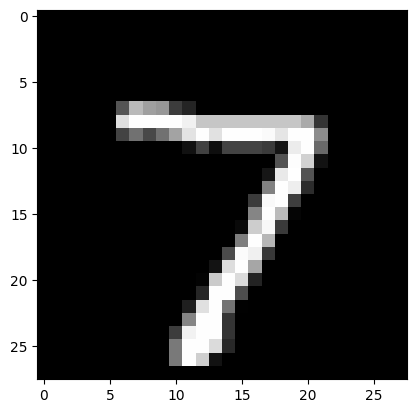

In [30]:
print("Plot the image")
plt.imshow(test_images_tensor[0].reshape(28, 28), cmap="gray")
plt.show()

## Debugging information

In [31]:
# print the featuers
print("Features:", test_features[0])

Features: [ 1.711e+03  1.410e+02  1.228e+03 -3.260e+02  4.110e+02 -9.950e+02
 -1.290e+02 -1.290e+02 -1.066e+03 -1.476e+03  1.320e+02  5.360e+02
 -1.162e+03 -1.420e+03 -7.900e+01 -3.900e+01  1.083e+03  1.459e+03
  8.000e-01  1.000e+00]


In [32]:
# convert test_features[0] into a javascript array
js_array = "["
for i in range(len(test_features[0])):
    js_array += str(test_features[0][i]) + ", "
js_array += "]"

print("Javascript array:", js_array)

Javascript array: [1711.0, 141.0, 1228.0, -326.0, 411.0, -995.0, -129.0, -129.0, -1066.0, -1476.0, 132.0, 536.0, -1162.0, -1420.0, -79.0, -39.0, 1083.0, 1459.0, 0.8, 1.0, ]


In [33]:
# convert test_images_tensor[0] into a javascript array
js_array = "["
for item in test_images_tensor[0].tolist():
    js_array += str(item) + ", "
js_array = js_array.rstrip(', ')  # Remove the trailing comma and space
js_array += "]"

print(js_array)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0,

In [34]:
print(cropped_test_image_0)

[[ 84 185 159 151  60  36   0   0   0   0   0   0   0   0   0   0]
 [222 254 254 254 254 241 198 198 198 198 198 198 198 198 170  52]
 [ 67 114  72 114 163 227 254 225 254 254 254 250 229 254 254 140]
 [  0   0   0   0   0  17  66  14  67  67  67  59  21 236 254 106]
 [  0   0   0   0   0   0   0   0   0   0   0   0  83 253 209  18]
 [  0   0   0   0   0   0   0   0   0   0   0  22 233 255  83   0]
 [  0   0   0   0   0   0   0   0   0   0   0 129 254 238  44   0]
 [  0   0   0   0   0   0   0   0   0   0  59 249 254  62   0   0]
 [  0   0   0   0   0   0   0   0   0   0 133 254 187   5   0   0]
 [  0   0   0   0   0   0   0   0   0   9 205 248  58   0   0   0]
 [  0   0   0   0   0   0   0   0   0 126 254 182   0   0   0   0]
 [  0   0   0   0   0   0   0   0  75 251 240  57   0   0   0   0]
 [  0   0   0   0   0   0   0  19 221 254 166   0   0   0   0   0]
 [  0   0   0   0   0   0   3 203 254 219  35   0   0   0   0   0]
 [  0   0   0   0   0   0  38 254 254  77   0   0   0   0   0 

In [35]:
print(test_images_resized[0].reshape(new_size, new_size))

[[ 84. 185. 155.  60.  36.   0.   0.   0.   0.   0.   0.   0.]
 [144. 184. 174. 208. 234. 219. 226. 226. 225. 214. 226. 154.]
 [  0.   0.   0.   0.   8.  20.  34.  34.  32.  52. 244. 147.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  11. 233. 255.  42.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 109. 254. 150.  11.]
 [  0.   0.   0.   0.   0.   0.   0.   4. 210. 122.   2.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 126. 218.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   5. 148. 252. 116.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 124. 254. 148.   9.   0.   0.   0.]
 [  0.   0.   0.   0.  31. 239. 115.   1.   0.   0.   0.   0.]
 [  0.   0.   0.  30. 188. 254.  52.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 121. 254. 174.  20.   0.   0.   0.   0.   0.]]


## Let's train a decision tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=9, random_state=0)
tree.fit(train_features_normalized, train_labels_tensor)

DecisionTreeClassifier(max_depth=9, random_state=0)

In [37]:
from sklearn.metrics import accuracy_score

def acc(y_true, y_pred):
    return accuracy_score(y_true, y_pred) * 100  # Multiply by 100 to get percentage

# Evaluate the baseline model
train_preds_baseline = tree.predict(train_features_normalized)
val_preds_baseline = tree.predict(test_features_normalized)
acc_baseline_train = acc(train_preds_baseline, train_labels_tensor)
acc_baseline_val = acc(val_preds_baseline, test_labels_tensor)
print(
    "Training accuracy for our baseline: "
    f"{acc_baseline_train:.2f}%"
)
print(
    "Validation accuracy for our baseline: "
    f"{acc_baseline_val:.2f}%"
)

Training accuracy for our baseline: 83.76%
Validation accuracy for our baseline: 82.32%


In [38]:
import logging
# Set the logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

tree_transpiler = LeoTranspiler(model=tree, validation_data=train_features_normalized.numpy()[0:200])
leo_project_path = os.path.join(os.getcwd(), "tmp/mnist")
leo_project_name = "tree_mnist_1"
tree_transpiler.to_leo(path=leo_project_path, project_name=leo_project_name, fixed_point_scaling_factor=16)

INFO:root:Computing number ranges and fixed-point scaling factor...
INFO:root:Minimum number: -3.603619337081909, maximum number: 5.416624069213867. Recommended fixed-point scaling factor: 16, required Leo type: i64
INFO:root:Transpiling model...
INFO:root:Leo program stored


In [39]:
# prove and compare the Leo prediction with the Python prediction and the label
zkp = tree_transpiler.execute(input=test_features_normalized.numpy()[0])
python_prediction = tree.predict([test_features_normalized[0]])

print(f"Circuit constraints: {zkp.circuit_constraints}")
print(f"Runtime: {zkp.runtime} seconds")
print(f"Active input count: {zkp.active_input_count}")
print(f"Leo prediction in fixed-point notation: {zkp.output[0]}")
print(f"Leo prediction in decimal notation: {zkp.output_decimal[0]}")
print(f"Python prediction: {python_prediction[0]}")
print(f"Label: {test_labels[0]}")

Circuit constraints: 32305
Runtime: 12.573861122131348 seconds
Active input count: 20
Leo prediction in fixed-point notation: 112
Leo prediction in decimal notation: 7.0
Python prediction: 7
Label: 7


## Debugging

In [40]:
# print the featuers
print("Features:", test_features[0])

Features: [ 1.711e+03  1.410e+02  1.228e+03 -3.260e+02  4.110e+02 -9.950e+02
 -1.290e+02 -1.290e+02 -1.066e+03 -1.476e+03  1.320e+02  5.360e+02
 -1.162e+03 -1.420e+03 -7.900e+01 -3.900e+01  1.083e+03  1.459e+03
  8.000e-01  1.000e+00]


tree
input_array (16) ['{x0: 27424i64, x1: 2240i64}', '{x0: 19664i64, x1: -5200i64}', '{x0: 6544i64, x1: -15952i64}', '{x0: -2080i64, x1: -2080i64}', '{x0: -17072i64}', '{x0: -23632i64}', '{x0: 2144i64}', '{x0: 8576i64}', '{x0: -18608i64}', '{x0: -22768i64}', '{x0: -1264i64}', '{x0: -592i64}', '{x0: 17344i64}', '{x0: 23360i64}', '{x0: 13i64}', '{x0: 16i64}']

mlp
input_array (16) ['{x0: 27424i64, x1: 2240i64}', '{x0: 19664i64, x1: -5200i64}', '{x0: 6544i64, x1: -15952i64}', '{x0: -2080i64, x1: -2080i64}', '{x0: -17072i64}', '{x0: -23632i64}', '{x0: 2144i64}', '{x0: 8576i64}', '{x0: -18608i64}', '{x0: -22768i64}', '{x0: -1264i64}', '{x0: -592i64}', '{x0: 17344i64}', '{x0: 23360i64}', '{x0: 13i64}', '{x0: 16i64}']

In [41]:
features_hardcoded_in_js = [1711.0, 141.0, 1228.0, -326.0, 411.0, -995.0, -129.0, -129.0, -1066.0, -1476.0, 132.0, 536.0, -1162.0, -1420.0, -79.0, -39.0, 1083.0, 1459.0, 0.8, 1.0]
features_hardcoded_in_js_normalized = scaler.transform([features_hardcoded_in_js])

print(features_hardcoded_in_js)
print(features_hardcoded_in_js_normalized)

[1711.0, 141.0, 1228.0, -326.0, 411.0, -995.0, -129.0, -129.0, -1066.0, -1476.0, 132.0, 536.0, -1162.0, -1420.0, -79.0, -39.0, 1083.0, 1459.0, 0.8, 1.0]
[[ 1.78925996e+00  9.61990745e-01  9.67135916e-01 -9.42821701e-02
   2.22980720e-01 -1.11685351e+00 -1.01618260e-01  3.67123035e-01
  -8.91444517e-01 -1.24020654e+00  1.21819260e-01  1.46586005e-01
  -8.15033940e-01 -8.08841700e-01  2.13862839e-02 -8.74995973e-02
   9.98446191e-01  7.20864356e-01 -1.25764494e-03 -7.47536740e-01]]


In [42]:
# prove and compare the Leo prediction with the Python prediction and the label
zkp = tree_transpiler.execute(input=features_hardcoded_in_js_normalized[0])
python_prediction = tree.predict(features_hardcoded_in_js_normalized)

print(f"Circuit constraints: {zkp.circuit_constraints}")
print(f"Runtime: {zkp.runtime} seconds")
print(f"Active input count: {zkp.active_input_count}")
print(f"Leo prediction in fixed-point notation: {zkp.output[0]}")
print(f"Leo prediction in decimal notation: {zkp.output_decimal[0]}")
print(f"Python prediction: {python_prediction[0]}")
print(f"Label: {test_labels[0]}")

Circuit constraints: 32305
Runtime: 6.674022197723389 seconds
Active input count: 20
Leo prediction in fixed-point notation: 112
Leo prediction in decimal notation: 7.0
Python prediction: 7
Label: 7


In [43]:
print(test_features_normalized[0])

tensor([ 1.7893e+00,  9.6199e-01,  9.6714e-01, -9.4282e-02,  2.2298e-01,
        -1.1169e+00, -1.0162e-01,  3.6712e-01, -8.9144e-01, -1.2402e+00,
         1.2182e-01,  1.4659e-01, -8.1503e-01, -8.0884e-01,  2.1386e-02,
        -8.7500e-02,  9.9845e-01,  7.2086e-01, -1.2576e-03, -7.4754e-01])


## Create even/odd labels

In [44]:
train_labels_even_odd = np.ones(len(train_labels_tensor))
train_labels_even_odd[train_labels_tensor % 2 == 0] = 0
train_labels_even_odd_tensor = torch.tensor(train_labels_even_odd).long()

validation_labels_even_odd = np.ones(len(validation_labels_tensor))
validation_labels_even_odd[validation_labels_tensor % 2 == 0] = 0
validation_labels_even_odd_tensor = torch.tensor(validation_labels_even_odd).long()

test_labels_even_odd = np.ones(len(test_labels_tensor))
test_labels_even_odd[test_labels_tensor % 2 == 0] = 0
test_labels_even_odd_tensor = torch.tensor(test_labels_even_odd).long()

## Let's train an MLP network

In [45]:
# Hyperparameters
input_dim = train_features_normalized.shape[1]
output_dim = len(set(train_labels_even_odd))  # Assuming train_labels are class indices
hidden_dim = (input_dim + output_dim) // 2

# Instantiate the model
model_even_odd = SimpleNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

In [46]:
# Train the model
model_even_odd, epochs, val_loss = train(model_even_odd, train_labels_even_odd_tensor, validation_labels_even_odd_tensor)

Epoch [100], Loss: 0.4227, validation loss: 0.4206
Epoch [200], Loss: 0.3066, validation loss: 0.3048
Epoch [300], Loss: 0.2462, validation loss: 0.2455
Epoch [400], Loss: 0.2103, validation loss: 0.2084
Epoch [500], Loss: 0.1893, validation loss: 0.1856
Epoch [600], Loss: 0.1763, validation loss: 0.1710
Epoch [700], Loss: 0.1679, validation loss: 0.1611
Epoch [800], Loss: 0.1618, validation loss: 0.1539
Epoch [900], Loss: 0.1571, validation loss: 0.1485
Epoch [1000], Loss: 0.1535, validation loss: 0.1443
Epoch [1100], Loss: 0.1507, validation loss: 0.1410
Epoch [1200], Loss: 0.1485, validation loss: 0.1384
Epoch [1300], Loss: 0.1465, validation loss: 0.1365
Epoch [1400], Loss: 0.1450, validation loss: 0.1349
Epoch [1500], Loss: 0.1435, validation loss: 0.1335
Epoch [1600], Loss: 0.1422, validation loss: 0.1322
Epoch [1700], Loss: 0.1412, validation loss: 0.1312
Epoch [1800], Loss: 0.1402, validation loss: 0.1303
Epoch [1900], Loss: 0.1394, validation loss: 0.1298
Epoch [2000], Loss: 0

In [47]:
evaluate_model(model_even_odd, test_labels_even_odd)

Accuracy: 0.9598


0.9598

## Let's prune the model and convert it to scikit-learn

In [48]:
model_even_odd_pruned = copy.deepcopy(model_even_odd)
model_even_odd_pruned, hooks = prune_pytorch_network(model_even_odd_pruned, 1e-1, 1e-1)

_ = evaluate_model(model_even_odd_pruned, test_labels_even_odd)

Number of weight parameters: 242
Number of weights already zero: 0
Number of changed weight parameters: 62
Number of bias parameters: 13
Number of biases already zero: 0
Number of changed bias parameters: 2
Percentage of weights pruned: 25.62%
Percentage of biases pruned: 15.38%
Remaining number of non-zero weights: 180
Remaining number of non-zero biases: 11
Accuracy: 0.9559


In [49]:
converted_model_even_odd = pytorch_to_sklearn(model_even_odd_pruned)

/Users/kp/miniconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


## Let's transpile

In [50]:
# Transpile the deceision tree into Leo code
print(type(converted_model_even_odd))
lt = LeoTranspiler(
    model=converted_model_even_odd, validation_data=train_features_normalized[0:600].numpy()
)
leo_project_path = os.path.join(os.getcwd(), "tmp", "mnist")
leo_project_name = "sklearn_mlp_mnist_2"
lt.to_leo(
    path=leo_project_path, project_name=leo_project_name, fixed_point_scaling_factor=16
)

# Compute the accuracy of the Leo program and the Python program on the test set
num_test_samples = len(test_features)

# let's limit the number of test stamples to 10 to make the computation faster
num_test_samples = min(num_test_samples, 20)

python_predictions = np.zeros(num_test_samples)

leo_predictions = np.zeros(num_test_samples)
for i in range(num_test_samples):
    lc = lt.run(input=test_features[i])
    leo_predictions[i] = np.argmax(lc.output_decimal)
    python_predictions[i] = converted_model_even_odd.predict(test_features[i].reshape(1,-1)).argmax()


print(f"Constraints: {lc.circuit_constraints}")
print(f"Runtime for one instance: {lc.runtime} seconds")

leo_accuracy = (
    np.sum(leo_predictions[0:num_test_samples] == test_labels_even_odd[0:num_test_samples])
    / num_test_samples
)
python_accuracy = (
    np.sum(python_predictions[0:num_test_samples] == test_labels_even_odd[0:num_test_samples])
    / num_test_samples
)

print(f"Leo accuracy: {100*leo_accuracy} %")
print(f"Python accuracy: {100*python_accuracy} %")

INFO:root:Computing number ranges and fixed-point scaling factor...


<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>


INFO:root:Minimum number: -7.960461139678955, maximum number: 8.663869857788086. Recommended fixed-point scaling factor: 16, required Leo type: i64
INFO:root:Transpiling model...
INFO:root:Leo program stored


Constraints: 84630
Runtime for one instance: 3.0045650005340576 seconds
Leo accuracy: 85.0 %
Python accuracy: 85.0 %


## Let's train and transpile a decision tree

In [51]:
tree_even_odd = DecisionTreeClassifier(max_depth=9, random_state=0)
tree_even_odd.fit(train_features_normalized, train_labels_even_odd_tensor)

DecisionTreeClassifier(max_depth=9, random_state=0)

In [52]:
def acc(y_true, y_pred):
    return accuracy_score(y_true, y_pred) * 100  # Multiply by 100 to get percentage

# Evaluate the baseline model
train_preds_baseline = tree_even_odd.predict(train_features_normalized)
val_preds_baseline = tree_even_odd.predict(test_features_normalized)
acc_baseline_train = acc(train_preds_baseline, train_labels_even_odd_tensor)
acc_baseline_val = acc(val_preds_baseline, test_labels_even_odd_tensor)
print(
    "Training accuracy for our baseline: "
    f"{acc_baseline_train:.2f}%"
)
print(
    "Validation accuracy for our baseline: "
    f"{acc_baseline_val:.2f}%"
)

Training accuracy for our baseline: 93.03%
Validation accuracy for our baseline: 91.60%


In [53]:
tree_transpiler = LeoTranspiler(model=tree_even_odd, validation_data=train_features_normalized.numpy()[0:200])
leo_project_path = os.path.join(os.getcwd(), "tmp/mnist")
leo_project_name = "tree_mnist_2"
tree_transpiler.to_leo(path=leo_project_path, project_name=leo_project_name, fixed_point_scaling_factor=16)

INFO:root:Computing number ranges and fixed-point scaling factor...
INFO:root:Minimum number: -3.603619337081909, maximum number: 5.416624069213867. Recommended fixed-point scaling factor: 16, required Leo type: i64
INFO:root:Transpiling model...
INFO:root:Leo program stored


In [54]:
# prove and compare the Leo prediction with the Python prediction and the label
zkp = tree_transpiler.execute(input=test_features_normalized.numpy()[0])
python_prediction = tree.predict([test_features_normalized[0]])

print(f"Circuit constraints: {zkp.circuit_constraints}")
print(f"Runtime: {zkp.runtime} seconds")
print(f"Active input count: {zkp.active_input_count}")
print(f"Leo prediction in fixed-point notation: {zkp.output[0]}")
print(f"Leo prediction in decimal notation: {zkp.output_decimal[0]}")
print(f"Python prediction: {python_prediction[0]}")
print(f"Label: {test_labels_even_odd[0]}")

Circuit constraints: 24508
Runtime: 22.241719007492065 seconds
Active input count: 20
Leo prediction in fixed-point notation: 16
Leo prediction in decimal notation: 1.0
Python prediction: 7
Label: 1.0
